In [ ]:
# import required packages
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import os
import random
import cv2
import math
import boto3
import numpy as np
from PIL import Image
from skimage import io
from skimage import exposure
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from sklearn.utils import shuffle
from tqdm import tqdm_notebook
from imutils import paths
%matplotlib inline

In [ ]:
# Connect to AWS S3 using provided access key ID and secret access key
s3 = boto3.client('s3',
                  aws_access_key_id='***',
                  aws_secret_access_key='***',
                  region_name='us-east-2')

In [ ]:
# Define S3 bucket name and directory
S3_BUCKET_NAME = 'drprojectbucket'
S3_TRAIN_IMAGES_PREFIX = 'train/'

In [ ]:
# Define local directory to store images
LOCAL_IMAGE_DIR = "./tmp/train/"

In [ ]:
# Function to download images from S3
def download_images_from_s3(bucket_name, prefix, local_dir):
    paginator = s3.get_paginator('list_objects')
    for result in paginator.paginate(Bucket=bucket_name, Delimiter='/', Prefix=prefix):
        if 'Contents' in result:
            for item in result['Contents']:
                key = item['Key']
                if key.endswith('.jpeg'):  # Assuming images are JPEG format
                    local_path = os.path.join(local_dir, os.path.basename(key))
                    s3.download_file(bucket_name, key, local_path)

In [ ]:
# Download images from S3 to local directory
download_images_from_s3(S3_BUCKET_NAME, S3_TRAIN_IMAGES_PREFIX, LOCAL_IMAGE_DIR)

In [ ]:
# load the trainLabels from local dir (EC2 directory)
trainLabels = pd.read_csv("trainLabels.csv")
trainLabels.head()

,image,level
0,10_left,0
1,10_right,0
2,13_left,0
3,13_right,0
4,15_left,1


In [ ]:
# create folders within train to store images based on their label
!mkdir tmp/train/0
!mkdir tmp/train/1
!mkdir tmp/train/2
!mkdir tmp/train/3
!mkdir tmp/train/4


In [ ]:
listing = os.listdir("tmp/train") 
base_dir = "tmp/train/"

for file in listing:
    try:
        fileName = os.path.splitext(file)[0]
        folder_name = trainLabels.loc[trainLabels.image==fileName, 'level'].values[0]  
        os.rename(base_dir + file, base_dir + str(folder_name) + "/" + file )
    except:
        print("error")
        pass

In [ ]:
def variance_of_laplacian(image):
    """
    Calculate the variance of the Laplacian of an image.
    
    Parameters:
        image (numpy.ndarray): Input image as a NumPy array.
        
    Returns:
        float: Variance of the Laplacian.
    """
    # Compute the Laplacian of the image and then return the focus measure,
    # which is simply the variance of the Laplacian
    return cv2.Laplacian(image, cv2.CV_64F).var()

In [ ]:
def blur_check(PATH): 
    """
    Check for image blur by computing the variance of the Laplacian.
    
    Parameters:
        PATH (str): Path to the directory containing images.
        
    Returns:
        dict: A dictionary mapping image filenames to their blur scores.
    """
    image_dict = {}
    list_of_images = os.listdir(PATH)
    for im in list_of_images:
        image = cv2.imread(PATH + im)
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        fm = variance_of_laplacian(gray)
        image_dict[im] = fm
    return image_dict

In [ ]:
def resize(PATH):
    """
    Resize images in a directory to (512, 512) using OpenCV.
    
    Parameters:
        PATH (str): Path to the directory containing images.
    """
    images = os.listdir(PATH);
    for image in images:
        name = PATH + image
        im = cv2.imread(name)
        im = cv2.resize(im, (512, 512));
        cv2.imwrite(name, im)

In [ ]:
def remove_blur_images(BASE_DIR, to_delete):
    """
    Remove blurry images from a directory.
    
    Parameters:
        BASE_DIR (str): Base directory where images are located.
        to_delete (list): List of filenames of images to be deleted.
    """
    for file in to_delete:
        os.remove(BASE_DIR + file)

In [ ]:
def data_aug_val(path):
    """
    Apply data augmentation techniques to images in a directory.
    
    Parameters:
        path (str): Path to the directory containing images.
    """
    listing_test = os.listdir(path)
    for file_name in listing_test:
        image = io.imread(path + file_name)
        v_min, v_max = np.percentile(image, (0.2, 99.8))
        better_contrast = exposure.rescale_intensity(image, in_range=(v_min, v_max))
        log_correction_image = exposure.adjust_log(image)
        sigmoid_correction_image = exposure.adjust_sigmoid(image)
        horizontal_flip = image[:, ::-1]
        io.imsave(path + str(1) + file_name, better_contrast)
        io.imsave(path + str(2) + file_name, log_correction_image)
        io.imsave(path + str(3) + file_name, sigmoid_correction_image)

In [ ]:
def remove_excess_images(PATH, number):
    """
    Remove excess images from a directory.
    
    Parameters:
        PATH (str): Path to the directory containing images.
        number (int): Number of images to keep.
    """
    listing = os.listdir(PATH) 
    to_delete = random.sample(listing, number)
    for file in to_delete:
        os.remove(PATH + file)

In [ ]:
def data_aug_val_1(path):
    """
    Apply specific data augmentation techniques to images in a directory.
    
    Parameters:
        path (str): Path to the directory containing images.
    """
    listing_test = os.listdir(path)
    for file_name in listing_test:
        image = io.imread(path + file_name)
        log_correction_image = exposure.adjust_log(image)
        io.imsave(path + str(2) + file_name, log_correction_image)

In [ ]:
# Resize the images
%time resize("tmp/train/0/")
%time resize("tmp/train/1/")
%time resize("tmp/train/2/")
%time resize("tmp/train/3/")
%time resize("tmp/train/4/")

CPU times: user 39min 41s, sys: 1min 44s, total: 41min 26s
Wall time: 40min 25s
CPU times: user 39min 41s, sys: 1min 44s, total: 41min 26s
Wall time: 40min 25s
CPU times: user 3min 43s, sys: 10.1 s, total: 3min 53s
Wall time: 3min 47s
CPU times: user 3min 43s, sys: 10.1 s, total: 3min 53s
Wall time: 3min 47s
CPU times: user 8min 25s, sys: 22.6 s, total: 8min 47s
Wall time: 8min 34s
CPU times: user 8min 25s, sys: 22.6 s, total: 8min 47s
Wall time: 8min 34s
CPU times: user 1min 24s, sys: 3.61 s, total: 1min 28s
Wall time: 1min 26s
CPU times: user 1min 24s, sys: 3.61 s, total: 1min 28s
Wall time: 1min 26s
CPU times: user 1min 9s, sys: 2.96 s, total: 1min 12s
Wall time: 1min 10s
CPU times: user 1min 9s, sys: 2.96 s, total: 1min 12s
Wall time: 1min 10s


Calculate blur score for images in directory "0" and remove blurry images

In [ ]:
# calculate blur scores for images in directory "0"
%time dict_sharp = blur_check("./tmp/train/0/")

CPU times: user 3min 34s, sys: 25.3 s, total: 4min
Wall time: 3min 34s
CPU times: user 3min 34s, sys: 25.3 s, total: 4min
Wall time: 3min 34s


In [ ]:
# Creating a dataframe of blur scores and image names
val_series = pd.Series(dict_sharp)
df = pd.DataFrame(val_series,columns=["val"])
df.sort_values(by='val',inplace=True)
df.reset_index(level=0, inplace=True)

In [ ]:
df.head(3000).tail(10)

,index,val
2990,23233_left.jpeg,29.951339
2991,13042_left.jpeg,29.955024
2992,38243_right.jpeg,29.963623
2993,41312_left.jpeg,29.971027
2994,20316_left.jpeg,29.976616
2995,13196_right.jpeg,29.979807
2996,33159_left.jpeg,29.982596
2997,38162_left.jpeg,29.989548
2998,43225_right.jpeg,29.992973
2999,14933_right.jpeg,29.996082


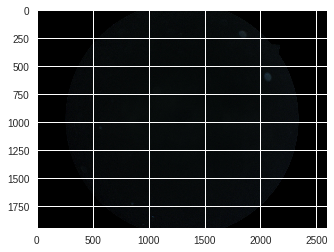

In [ ]:
# Display the image with the lowest blur score from directory "tmp/train/0/"
image = cv2.imread("./tmp/train/0/27481_right.jpeg")
plt.imshow(image);
plt.show()

In [ ]:
# Remove blurry images from directory "tmp/train/0/"
to_delete = df["index"].head(3000).tolist()
remove_blur_images("./tmp/train/0/",to_delete)

In [ ]:
!ls tmp/train/0 | wc -l

22810


Calculate blur score for images in directory "1" and remove blurry images

In [ ]:
# Calculate blur scores for images in directory "tmp/train/1/"
%time dict_sharp = blur_check("./tmp/train/1/")

CPU times: user 20.3 s, sys: 3.23 s, total: 23.6 s
Wall time: 21.1 s


In [ ]:
frame = pd.Series(dict_sharp)
df = pd.DataFrame(frame,columns=["val"])
df.sort_values(by='val',inplace=True)
df.reset_index(level=0, inplace=True)

In [ ]:
df.head(100).tail()

,index,val
95,13043_right.jpeg,23.295280
96,30205_left.jpeg,23.316267
97,393_right.jpeg,23.355272
98,41105_right.jpeg,23.369600
99,39832_left.jpeg,23.531645


In [ ]:
# Remove blurry images from directory "tmp/train/1/"
to_delete = df["index"].head(100).tolist()

In [ ]:
remove_blur_images("./tmp/train/1/",to_delete)

In [ ]:
!ls tmp/train/1 | wc -l

2343


Calculate blur score for images in directory "2" and remove blurry images

In [ ]:
# Calculate blur scores for images in directory "tmp/train/2/"
%time dict_sharp = blur_check("./tmp/train/2/")

CPU times: user 43.5 s, sys: 6.05 s, total: 49.5 s
Wall time: 43.2 s


In [ ]:
frame = pd.Series(dict_sharp)
df = pd.DataFrame(frame,columns=["val"])
df.sort_values(by='val',inplace=True)
df.reset_index(level=0, inplace=True)

In [ ]:
df.head(250).tail()

,index,val
245,21447_right.jpeg,18.958998
246,33746_right.jpeg,18.960989
247,30069_left.jpeg,18.976494
248,9942_right.jpeg,18.976888
249,2357_left.jpeg,19.053912


In [ ]:
# Remove blurry images from directory "tmp/train/2/"
to_delete = df["index"].head(250).tolist()

In [ ]:
remove_blur_images("./tmp/train/2/",to_delete)

Calculate blur score for images in directory "3" and remove blurry images

In [ ]:
# Calculate blur scores for images in directory "tmp/train/3/"
%time dict_sharp = blur_check("./tmp/train/3/")

CPU times: user 7.25 s, sys: 983 ms, total: 8.23 s
Wall time: 7.19 s


In [ ]:
frame = pd.Series(dict_sharp)
df = pd.DataFrame(frame,columns=["val"])
df.sort_values(by='val',inplace=True)
df.reset_index(level=0, inplace=True)

In [ ]:
df.head(40).tail()

,index,val
35,8699_left.jpeg,16.152079
36,40259_left.jpeg,17.012925
37,5298_right.jpeg,17.035852
38,18971_left.jpeg,17.069210
39,34006_right.jpeg,17.433434


In [ ]:
# Remove blurry images from directory "tmp/train/3/"
to_delete = df["index"].head(40).tolist()

In [ ]:
remove_blur_images("./tmp/train/3/",to_delete)

Calculate blur score for images in directory "4" and remove blurry images

In [ ]:
# Calculate blur scores for images in directory "tmp/train/4/"
%time dict_sharp = blur_check("./tmp/train/4/")

CPU times: user 5.92 s, sys: 776 ms, total: 6.69 s
Wall time: 5.84 s


In [ ]:
frame = pd.Series(dict_sharp)
df = pd.DataFrame(frame,columns=["val"])
df.sort_values(by='val',inplace=True)
df.reset_index(level=0, inplace=True)

In [ ]:
df.head(30)

,index,val
0,30723_left.jpeg,4.110168
1,40178_left.jpeg,5.632523
2,30675_left.jpeg,7.969081
3,6613_right.jpeg,8.131547
4,41852_right.jpeg,8.718414
5,17411_right.jpeg,9.154816
6,35704_left.jpeg,9.200000
7,31659_right.jpeg,9.372860
8,40819_left.jpeg,10.066191
9,9298_right.jpeg,10.068080


In [ ]:
# Remove blurry images from directory "tmp/train/4/"
to_delete = df["index"].head(30).tolist()

In [ ]:
remove_blur_images("./tmp/train/4/",to_delete)

Print the number of images in each directory

In [ ]:
!ls tmp/train/0 | wc -l

22810


In [ ]:
!ls tmp/train/1 | wc -l

2343


In [ ]:
!ls tmp/train/2 | wc -l

5042


In [ ]:
!ls tmp/train/3 | wc -l

833


In [ ]:
!ls tmp/train/4 | wc -l

678


In [ ]:
# Remove excess images from directory "tmp/train/0/"
remove_excess_images("tmp/train/0/",14000)

In [ ]:
!ls tmp/train/0 | wc -l

8810


Apply data augmentation techniques to images in directory train/1,3,4

In [ ]:
data_aug_val_1("tmp/train/1/")
data_aug_val("tmp/train/3/")
data_aug_val("tmp/train/4/")

In [1]:
def upload_images_to_s3_with_structure(bucket_name, local_dir, prefix):
    """
    Upload images to S3 with folder structure preserved.
    
    Parameters:
        bucket_name (str): The name of the S3 bucket.
        local_dir (str): The local directory containing the images.
        prefix (str): The prefix (folder) in the S3 bucket where images will be uploaded.
    """
    s3 = boto3.client('s3',
                      aws_access_key_id='***',
                      aws_secret_access_key='***',
                      region_name='us-east-2')

    for root, dirs, files in os.walk(local_dir):
        for file in files:
            local_path = os.path.join(root, file)
            # Extract subdirectory relative to local_dir
            relative_path = os.path.relpath(local_path, local_dir)
            # Combine prefix and relative_path to get S3 key
            s3_path = os.path.join(prefix, relative_path)
            # Upload file to S3
            s3.upload_file(local_path, bucket_name, s3_path)

In [ ]:
# Call the function
upload_images_to_s3_with_structure(S3_BUCKET_NAME, LOCAL_IMAGE_DIR, S3_TRAIN_IMAGES_PREFIX,)